In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior
import gc

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

### Try to test how kappa transforms into beta

In [2]:
from popsed.nde import _inv_beta_cdf, _beta_cdf

In [5]:
def gen_truth(N_samples=5000):
    ncomp = 4
    priors = prior.load_priors([
            # flat dirichilet priors for SFH
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.6),
            prior.UniformPrior(0., 1.,),
            prior.UniformPrior(0., 1.,),
            # uniform priors on the mass fraction of burst
            prior.TruncatedNormalPrior(0, 1, 0.1, 0.6, label='fburst'),
            # uniform priors on star-burst lookback time
            prior.TruncatedNormalPrior(1e-2, 13.27, 14, 7, label='tburst'),
            # uniform priors on log-metallicity, absolute Z
#             prior.UniformPrior(-2.6, 0.3, label='logzsol'),
            prior.TruncatedNormalPrior(-2.6, 0.3, -0.7, 0.9, label='logzsol'),
            # uniform priors on dust1
            prior.UniformPrior(0., 3., label='dust1'),
            # uniform priors on dust2
#             prior.BiGaussianPrior([0.3, 1.0], [[0.02, 0], [0, 0.05]], p1=0.3, label='dust2'),
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.8, label='dust2'),
            # uniform priors on dust_index
            prior.TruncatedNormalPrior(-3., 1., 2, 2, label='dust_index'),
            # uniformly sample redshift
#             prior.TruncatedNormalPrior(0, 0.78, 0.18, 0.1, label='redshift')
#             prior.TruncatedNormalPrior(7.5, 13, 11.0, 0.7, label='logmstar')
#             prior.TruncatedNormalPrior(0., 1.5, 0.08, 0.05, label='redshift')
        ])
    
    _thetas_unt = np.array([priors.sample() for i in range(N_samples)])
#     _thetas_unt[:, 1] = _beta_cdf(np.random.uniform(0, 1, N_samples), 2, 1)
    for i in range(3):
        _thetas_unt[:, i:i + 1] = _inv_beta_cdf(_thetas_unt[:, i:i + 1], 3 - i, 1)
    _thetas = np.hstack([
#                _thetas_unt[:, 0:1], 
               prior.FlatDirichletPrior(4).transform(_thetas_unt[:, 0:3]), 
               _thetas_unt[:, 3:]])
    
    return _thetas, _thetas_unt

In [6]:
# z_mass_mock = np.load('./NDE/GAMA/NMF/z_mass_mock.npy')
z_mass_mock = np.load('./reference_catalog/GAMA/gama_clean_z_mass_lambdar.npy')[:, :2]
# z_mass_mock = np.load('./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch.npy')[:, :2]
z_mass_mock = z_mass_mock[(z_mass_mock[:, 1] > 7.5) & (z_mass_mock[:, 0] < 0.8)]
z_mass_mock = z_mass_mock[np.random.randint(0, len(z_mass_mock), 100000)]

In [7]:
_thetas, _thetas_unt = gen_truth(N_samples=len(z_mass_mock)) # slow

In [8]:
params = np.hstack([_thetas, z_mass_mock])
params_unt = np.hstack([_thetas_unt, z_mass_mock])

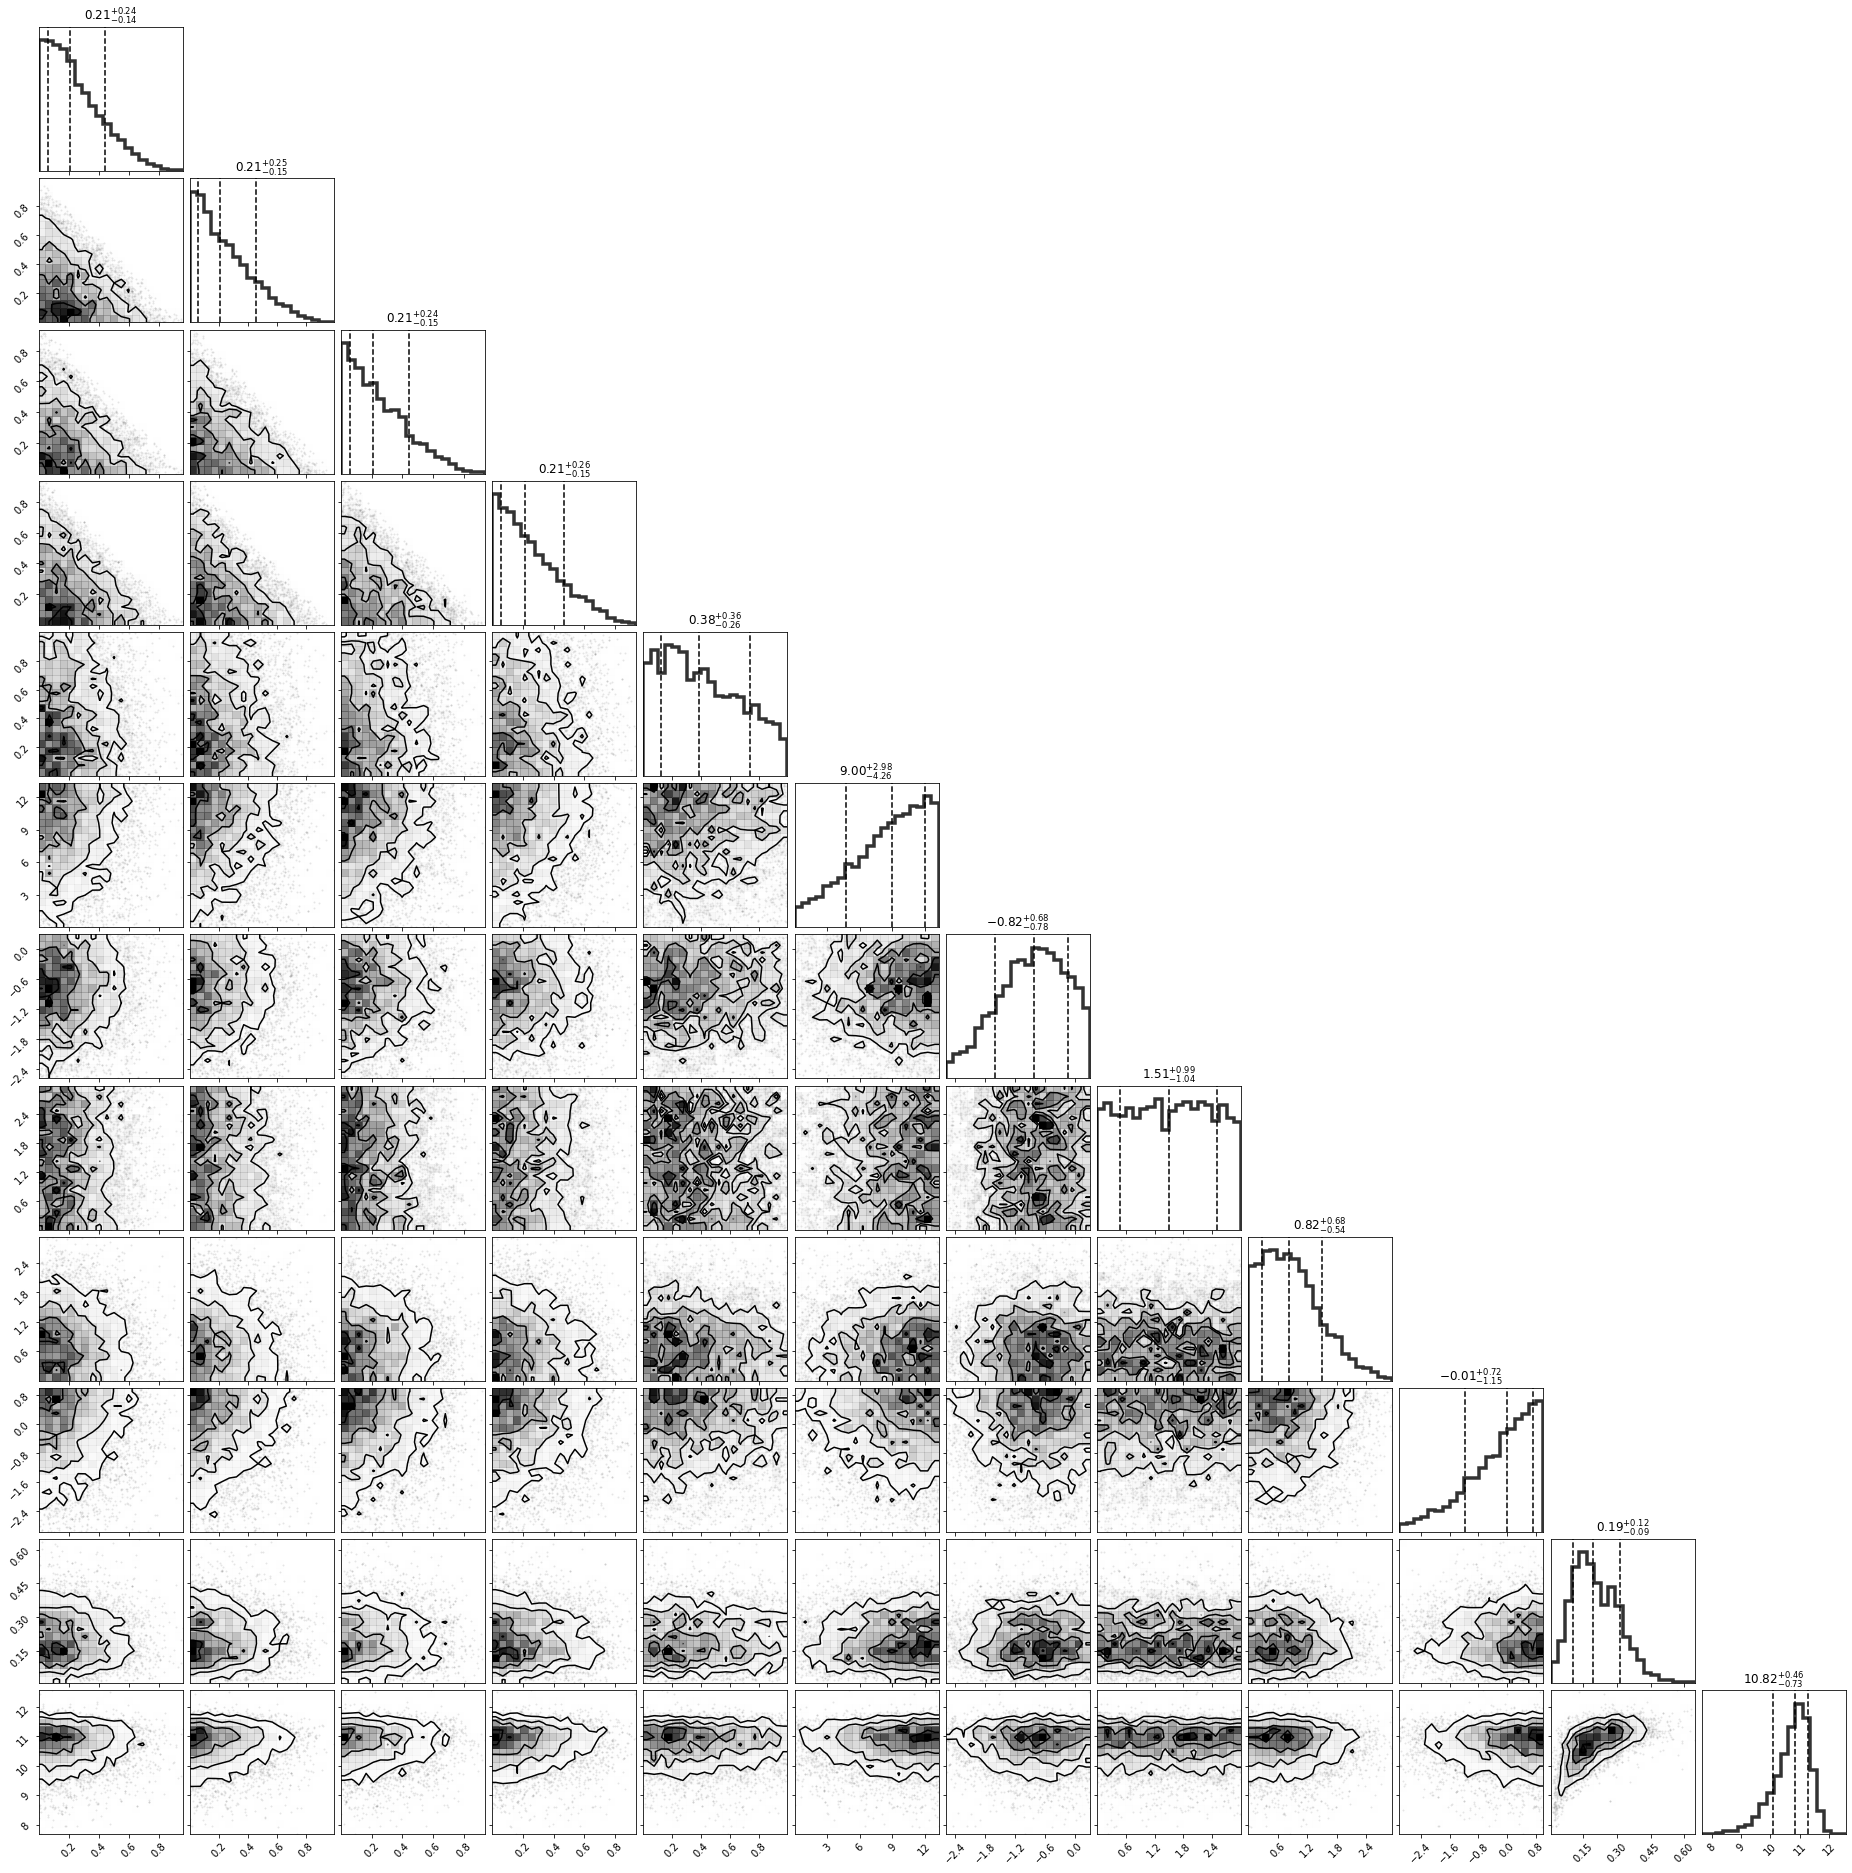

In [9]:
figure = corner.corner(params[np.random.randint(0, len(params), 5000)], #params, 
                       quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [3]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
name = 'NMF'
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=['.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol',
                 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'],
    device='cuda', use_speclite=True)


gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

noise = None # 'gama' #'snr' #None # 'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [4]:
params_unt = np.load('./NDE/GAMA/NMF/mock_params.npy')[np.]
# params = np.load('./NDE/GAMA/NMF/mock_params_trans.npy')

In [5]:
test_par = torch.Tensor(params_unt).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(test_par, noise=None, #SNR=5,
                                           noise_model_dir=noise_model_dir).detach().cpu().numpy()
np.save('./NDE/GAMA/NMF/mock_params.npy', params_unt)
np.save('./NDE/GAMA/NMF/mock_mags_no_noise.npy', mags)
del mags
torch.cuda.empty_cache()
gc.collect()

mags = speculator._predict_mag_with_mass_redshift(test_par, noise='gama', SNR=1,
                                           noise_model_dir=noise_model_dir).detach().cpu().numpy()
np.save('./NDE/GAMA/NMF/mock_mags_gama_apmatch_noise.npy', mags)
del mags
torch.cuda.empty_cache()
gc.collect()

mags = speculator._predict_mag_with_mass_redshift(test_par, noise='snr', SNR=5,
                                           noise_model_dir=noise_model_dir).detach().cpu().numpy()
np.save('./NDE/GAMA/NMF/mock_mags_snr_5.npy', mags)
del mags
torch.cuda.empty_cache()
gc.collect()

RuntimeError: CUDA out of memory. Tried to allocate 9.32 GiB (GPU 0; 39.45 GiB total capacity; 30.10 GiB already allocated; 5.92 GiB free; 32.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
del mags
torch.cuda.empty_cache()

#### Load GAMA photometry catalog

In [17]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [18]:
X_data = np.load('./NDE/GAMA/NMF/mock_mags_gama_noise.npy')[:, :]
print('Total number of samples:', len(X_data))

Total number of samples: 50000


In [19]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [20]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [21]:
_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0., 0.8])
_prior_NDE[-1] = np.array([7.5, 13.])

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

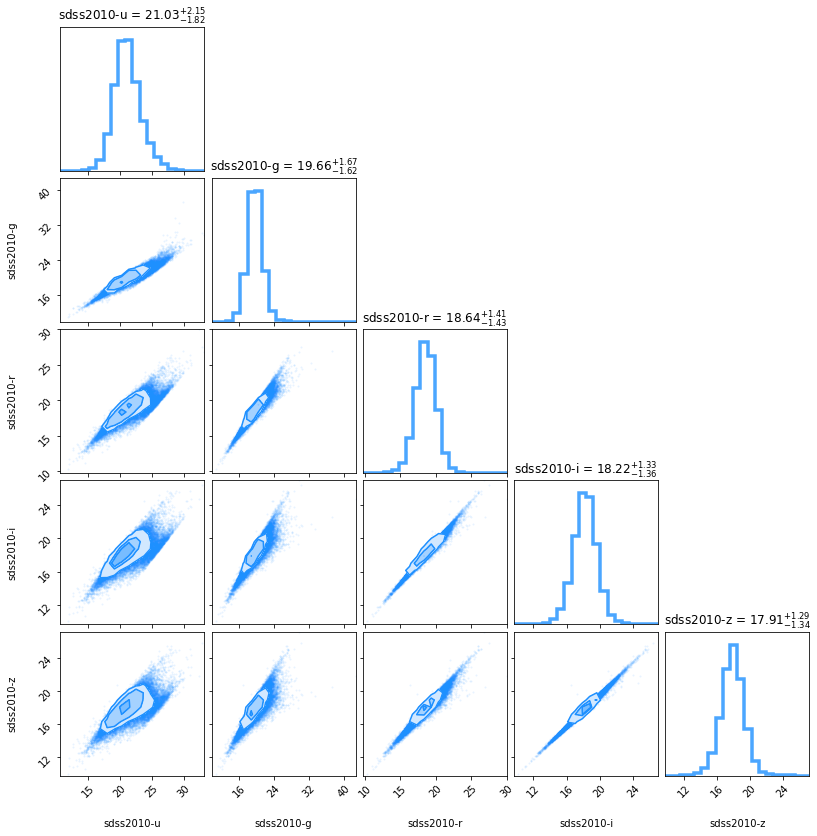

In [22]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = gama_filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(X_data,#.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# figure = corner.corner(mags,#.cpu().detach().numpy()[:, :], 
#                        fig=figure,
#                        color='gray', labels=labels,
#                        #quantiles=[0.16, 0.5, 0.84], 
#                        smooth=0.1, fill_contours=True,
#                        show_titles=True, 
#                        title_kwargs={"fontsize": 12},
#                        hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [9]:
# noise = 'gama'
# noise = None
# true_params_unt = np.load('./NDE/GAMA/NMF/mock_params.npy')
# true_params_unt = true_params_unt[np.random.randint(0, len(true_params_unt), 5000)]

p = 1
blur = 0.1, loss=0.07
blur = 0.01, loss=0.196
blur = 0.002, loss=0.204

p = 2
blur = 0.1, loss=0.012
blur = 0.01, loss=0.02
blur = 0.002, loss=0.0184

In [77]:
# min_loss = 0.11

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [23]:
X_train, X_vali = train_test_split(X_data, test_size=0.15)
if name == 'NMF_ZH':
    Y_train = torch.ones(len(X_train), 12)
else:
    Y_train = torch.ones(len(X_train), 11)

### now we provide the redshift distribution to it

In [54]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [55]:
seed = 42
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 30), 
                   np.abs(np.random.normal(size=len(_bounds)) / 30)]).T

_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name=name,
                                              num_transforms=30,  # 10
                                              num_bins=20,  # how smashed it is. 10
                                              hidden_features=100,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=_prior_NDE,#np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )

In [56]:
NDE_theta.build(
    Y_train,#[:, :-1],
    X_train,
    filterset=gama_filters,
    z_score=False,
    optimizer='adam', lr=1e-4)
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

NDE_theta.external_redshift_data = None

[-0.00454134  0.00744075  0.0408975   0.01404605 -0.00366312 -0.00132056
 -0.04897446  0.02279359  0.02205636  0.02931325 -0.01497437]
Total number of params in the model: 2218695


In [43]:
# del X_data
gc.collect()
torch.cuda.empty_cache()

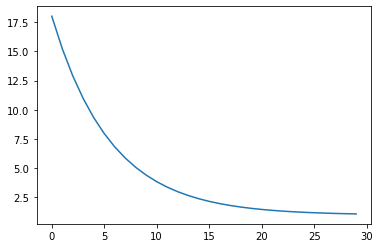

In [45]:
plt.plot([1 + 17 * 0.8**(0.8 * i) for i in range(30)])

In [58]:
noise = 'gama' #None #'gama' #None
# first old blurs
# then use 0.02
max_epochs = 30
# blurs = [0.001] * 5
# blurs = [0.2, 0.1, 0.1, 0.05, 0.05]
# blurs = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
# blurs = [0.2] * 6
steps = 20
# blurs = [0.3] * max_epochs
blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05] + [0.002] * 30
# blurs = [0.05, 0.05, 0.05]
# blurs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.01]

scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=4e-4, #3e-4, #4e-4, #2e-4, #3e-4, #8e-4, #5e-4,
                                                steps_per_epoch=steps,
                                                epochs=max_epochs,
                                                anneal_strategy='cos',
                                                div_factor=10, final_div_factor=100)

for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    np.save(f'./NDE/GAMA/NMF/sample_no_anneal_{i}.npy', NDE_theta.sample(5000).detach().cpu().numpy())
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=1, # + 17 * 0.8**(0.8 * i),
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.9},
                    scheduler=scheduler, detect_anomaly=False,
                    )
    
np.save(f'./NDE/GAMA/NMF/sample_no_anneal_{i+1}.npy', NDE_theta.sample(5000).detach().cpu().numpy())

    Epoch 0
    lr: 3.9999999999999996e-05
    blur: 0.3


Loss = 7.986 (train), 7.719 (vali), 6.690 (bad ratio): 100%|███████████| 20/20 [00:43<00:00,  2.17s/epochs]


    Epoch 1
    lr: 5.097570431960625e-05
    blur: 0.2


Loss = 4.748 (train), 4.611 (vali), 4.869 (bad ratio): 100%|███████████| 20/20 [00:44<00:00,  2.23s/epochs]


    Epoch 2
    lr: 8.256430521940924e-05
    blur: 0.1


Loss = 3.162 (train), 3.322 (vali), 2.491 (bad ratio): 100%|███████████| 20/20 [00:46<00:00,  2.33s/epochs]


    Epoch 3
    lr: 0.0001309135011066724
    blur: 0.1


Loss = 0.877 (train), 0.789 (vali), 2.691 (bad ratio): 100%|███████████| 20/20 [00:45<00:00,  2.30s/epochs]


    Epoch 4
    lr: 0.00019012699777973656
    blur: 0.05


Loss = 0.578 (train), 0.558 (vali), 2.213 (bad ratio): 100%|███████████| 20/20 [00:47<00:00,  2.39s/epochs]


    Epoch 5
    lr: 0.0002529835748917847
    blur: 0.05


Loss = 0.840 (train), 1.065 (vali), 1.462 (bad ratio): 100%|███████████| 20/20 [00:47<00:00,  2.38s/epochs]


    Epoch 6
    lr: 0.0003118177301658793
    blur: 0.002


Loss = 0.791 (train), 0.790 (vali), 2.907 (bad ratio): 100%|███████████| 20/20 [00:59<00:00,  2.96s/epochs]


    Epoch 7
    lr: 0.00035945450479999514
    blur: 0.002


Loss = 0.618 (train), 0.587 (vali), 2.267 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.94s/epochs]


    Epoch 8
    lr: 0.00039008448598164594
    blur: 0.002


Loss = 0.874 (train), 0.817 (vali), 1.512 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.94s/epochs]


    Epoch 9
    lr: 0.0003999944106072417
    blur: 0.002


Loss = 1.236 (train), 1.139 (vali), 1.540 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.95s/epochs]


    Epoch 10
    lr: 0.00039754013045090853
    blur: 0.002


Loss = 0.999 (train), 0.868 (vali), 1.483 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.95s/epochs]


    Epoch 11
    lr: 0.00039067759787505136
    blur: 0.002


Loss = 0.617 (train), 0.564 (vali), 2.203 (bad ratio): 100%|███████████| 20/20 [00:59<00:00,  2.95s/epochs]


    Epoch 12
    lr: 0.0003795601105174211
    blur: 0.002


Loss = 1.235 (train), 1.346 (vali), 1.252 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.95s/epochs]


    Epoch 13
    lr: 0.00036443601467449246
    blur: 0.002


Loss = 0.516 (train), 0.499 (vali), 2.767 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.93s/epochs]


    Epoch 14
    lr: 0.00034564315765558024
    blur: 0.002


Loss = 0.581 (train), 0.559 (vali), 1.658 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.93s/epochs]


    Epoch 15
    lr: 0.0003236013408322257
    blur: 0.002


Loss = 0.467 (train), 0.416 (vali), 1.964 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.93s/epochs]


    Epoch 16
    lr: 0.00029880294196925653
    blur: 0.002


Loss = 0.449 (train), 0.411 (vali), 2.124 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.94s/epochs]


    Epoch 17
    lr: 0.000271801916319151
    blur: 0.002


Loss = 0.389 (train), 0.364 (vali), 2.130 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.93s/epochs]


    Epoch 18
    lr: 0.0002432014221770807
    blur: 0.002


Loss = 0.476 (train), 0.440 (vali), 2.002 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.94s/epochs]


    Epoch 19
    lr: 0.00021364034732128555
    blur: 0.002


Loss = 0.740 (train), 0.986 (vali), 1.421 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.93s/epochs]


    Epoch 20
    lr: 0.00018377903731583823
    blur: 0.002


Loss = 0.533 (train), 0.493 (vali), 2.652 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.93s/epochs]


    Epoch 21
    lr: 0.00015428454448193114
    blur: 0.002


Loss = 0.453 (train), 0.437 (vali), 2.001 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.94s/epochs]


    Epoch 22
    lr: 0.00012581572705129136
    blur: 0.002


Loss = 0.435 (train), 0.443 (vali), 2.051 (bad ratio): 100%|███████████| 20/20 [00:59<00:00,  2.95s/epochs]


    Epoch 23
    lr: 9.900853136201487e-05
    blur: 0.002


Loss = 0.441 (train), 0.395 (vali), 2.097 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.94s/epochs]


    Epoch 24
    lr: 7.446178586824251e-05
    blur: 0.002


Loss = 0.407 (train), 0.383 (vali), 2.133 (bad ratio): 100%|███████████| 20/20 [00:58<00:00,  2.95s/epochs]


    Epoch 25
    lr: 5.272382430202936e-05
    blur: 0.002


Loss = 40.511 (train), 40.536 (vali), 10.000 (bad ratio): 100%|████████| 20/20 [00:56<00:00,  2.83s/epochs]


    Epoch 26
    lr: 3.428023680386443e-05
    blur: 0.002


Loss = 40.500 (train), 40.515 (vali), 10.000 (bad ratio): 100%|████████| 20/20 [00:55<00:00,  2.79s/epochs]


    Epoch 27
    lr: 1.9543022641345808e-05
    blur: 0.002


Loss = 40.512 (train), 40.525 (vali), 10.000 (bad ratio):   5%|▍        | 1/20 [00:03<01:11,  3.75s/epochs]


KeyboardInterrupt: 

In [90]:
noise = None
# first old blurs
# then use 0.02
max_epochs = 4
# blurs = [0.001] * 5
# blurs = [0.2, 0.1, 0.1, 0.05, 0.05]
# blurs = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
# blurs = [0.2] * 6
steps = 70
blurs = [0.01] * max_epochs
# blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.002, 0.002]
# blurs = [0.05, 0.05, 0.05]
# blurs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.01]

scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-4, #4e-4, #2e-4, #3e-4, #8e-4, #5e-4,
                                                steps_per_epoch=steps,
                                                epochs =max_epochs)
for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=10,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.5},
                    scheduler=scheduler, detect_anomaly=False,
                    )

    Epoch 0
    lr: 4.000000000000002e-06
    blur: 0.01


Loss = 0.280 (train), 0.288 (vali), 2.280 (bad ratio): 100%|█| 70/70 [02:07<00:00,


    Epoch 1
    lr: 9.430542716870315e-05
    blur: 0.01


Loss = 0.268 (train), 0.276 (vali), 2.291 (bad ratio): 100%|█| 70/70 [02:07<00:00,


    Epoch 2
    lr: 8.05440096293485e-05
    blur: 0.01


Loss = 0.266 (train), 0.272 (vali), 2.275 (bad ratio): 100%|█| 70/70 [02:07<00:00,


    Epoch 3
    lr: 2.7586859820559488e-05
    blur: 0.01


Loss = 0.264 (train), 0.269 (vali), 2.226 (bad ratio): 100%|█| 70/70 [02:07<00:00,


In [80]:
NDE_theta.save_model('./test_gama_mock_snr5_annealing.pkl')

In [75]:
with open('./test_gama_mock.pkl', 'rb') as f:
    NDE_theta = pickle.load(f)
NDE_theta.optimizer = optim.Adam(NDE_theta.net.parameters(), lr=5e-6)

In [ ]:
noise = 'gama'
# first old blurs
# then use 0.02
max_epochs = 5
# blurs = [0.001] * 5
# blurs = [0.2, 0.1, 0.1, 0.05, 0.05]
# blurs = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
blurs = [0.02] * 6
steps = 70
# blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.002, 0.002]
# blurs = [0.05, 0.05, 0.05]
# blurs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.01]

scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=0.5e-4, #4e-4, #2e-4, #3e-4, #8e-4, #5e-4,
                                                steps_per_epoch=steps,
                                                epochs =max_epochs)
for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=10,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.5},
                    scheduler=scheduler, detect_anomaly=False,
                    )

    Epoch 0
    lr: 2.000000000000001e-06
    blur: 0.02


Loss = 0.254 (train), 0.265 (vali), 2.205 (bad ratio): 100%|█| 70/70 [02:12<00:00,


    Epoch 1
    lr: 3.841610754026377e-05
    blur: 0.02


Loss = 0.265 (train), 0.264 (vali), 2.486 (bad ratio): 100%|█| 70/70 [02:12<00:00,


    Epoch 2
    lr: 4.73832938251854e-05
    blur: 0.02


Loss = 0.476 (train), 0.539 (vali), 1.480 (bad ratio): 100%|█| 70/70 [02:12<00:00,


    Epoch 3
    lr: 3.0250120267156165e-05
    blur: 0.02


Loss = 0.305 (train), 0.313 (vali), 2.157 (bad ratio):  83%|▊| 58/70 [01:49<00:22,

In [161]:
for i, epoch in enumerate(range(3)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=10,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.8},
                    scheduler=None, detect_anomaly=False,
                    lr=lrs[i]
                    )

    Epoch 0
    lr: 1e-05
    blur: 0.0001


Loss = 3.016 (train), 2.924 (vali), 1.517 (bad ratio):  38%|▍| 38/100 [01:53<03:05


KeyboardInterrupt: 

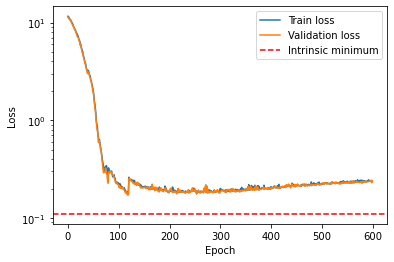

In [47]:
NDE_theta.plot_loss(0.11)
plt.yscale('log')

# plt.xlim(600, 1000)

In [48]:
samples = NDE_theta.sample(5000)
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                      _samples_unt[:, 3:-1], 
                      _samples_unt[:, -1:]])

0 5000
>40 0


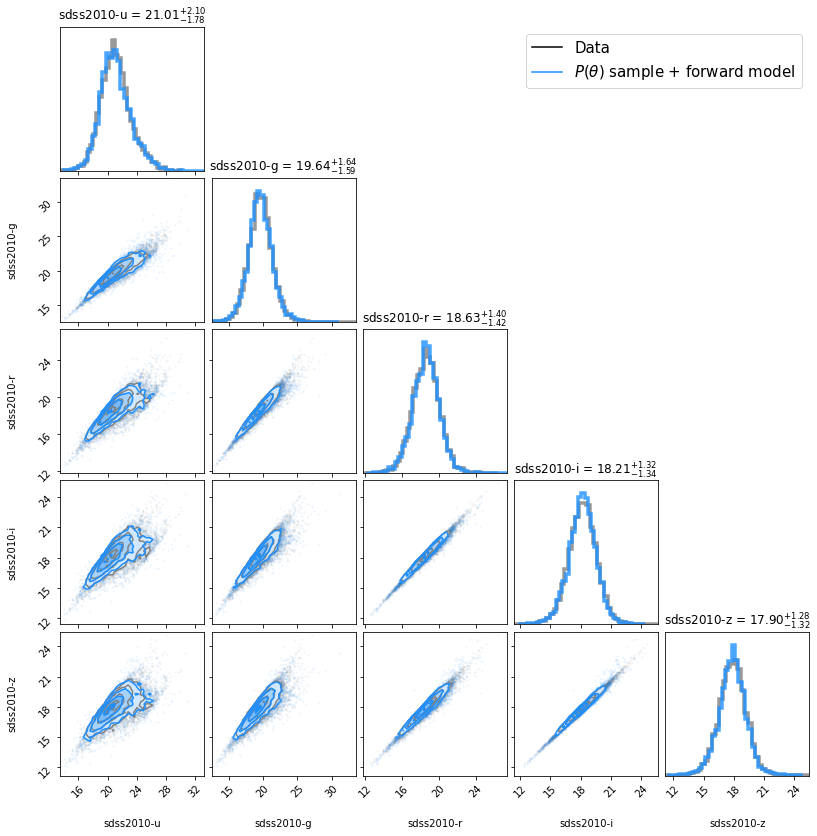

In [53]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = gama_filters

figure = corner.corner(X_vali,#.cpu().detach().numpy(), 
                       color='gray', labels=labels, bins=40,
                       smooth=0.2, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(
#     inverse_transform_nmf_params_given_z(samples, NDE_theta.NDE_prior, NDE_theta.cdf_z), 
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir, SNR=1,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=40,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [50]:
true_params_unt = np.load('./NDE/GAMA/NMF/mock_params.npy')
true_params_unt = true_params_unt[np.random.randint(0, len(true_params_unt), 5000)]
true_params = np.hstack([prior.FlatDirichletPrior(4).transform(true_params_unt[:, :3]),
                      true_params_unt[:, 3:-1], 
                      true_params_unt[:, -1:]])

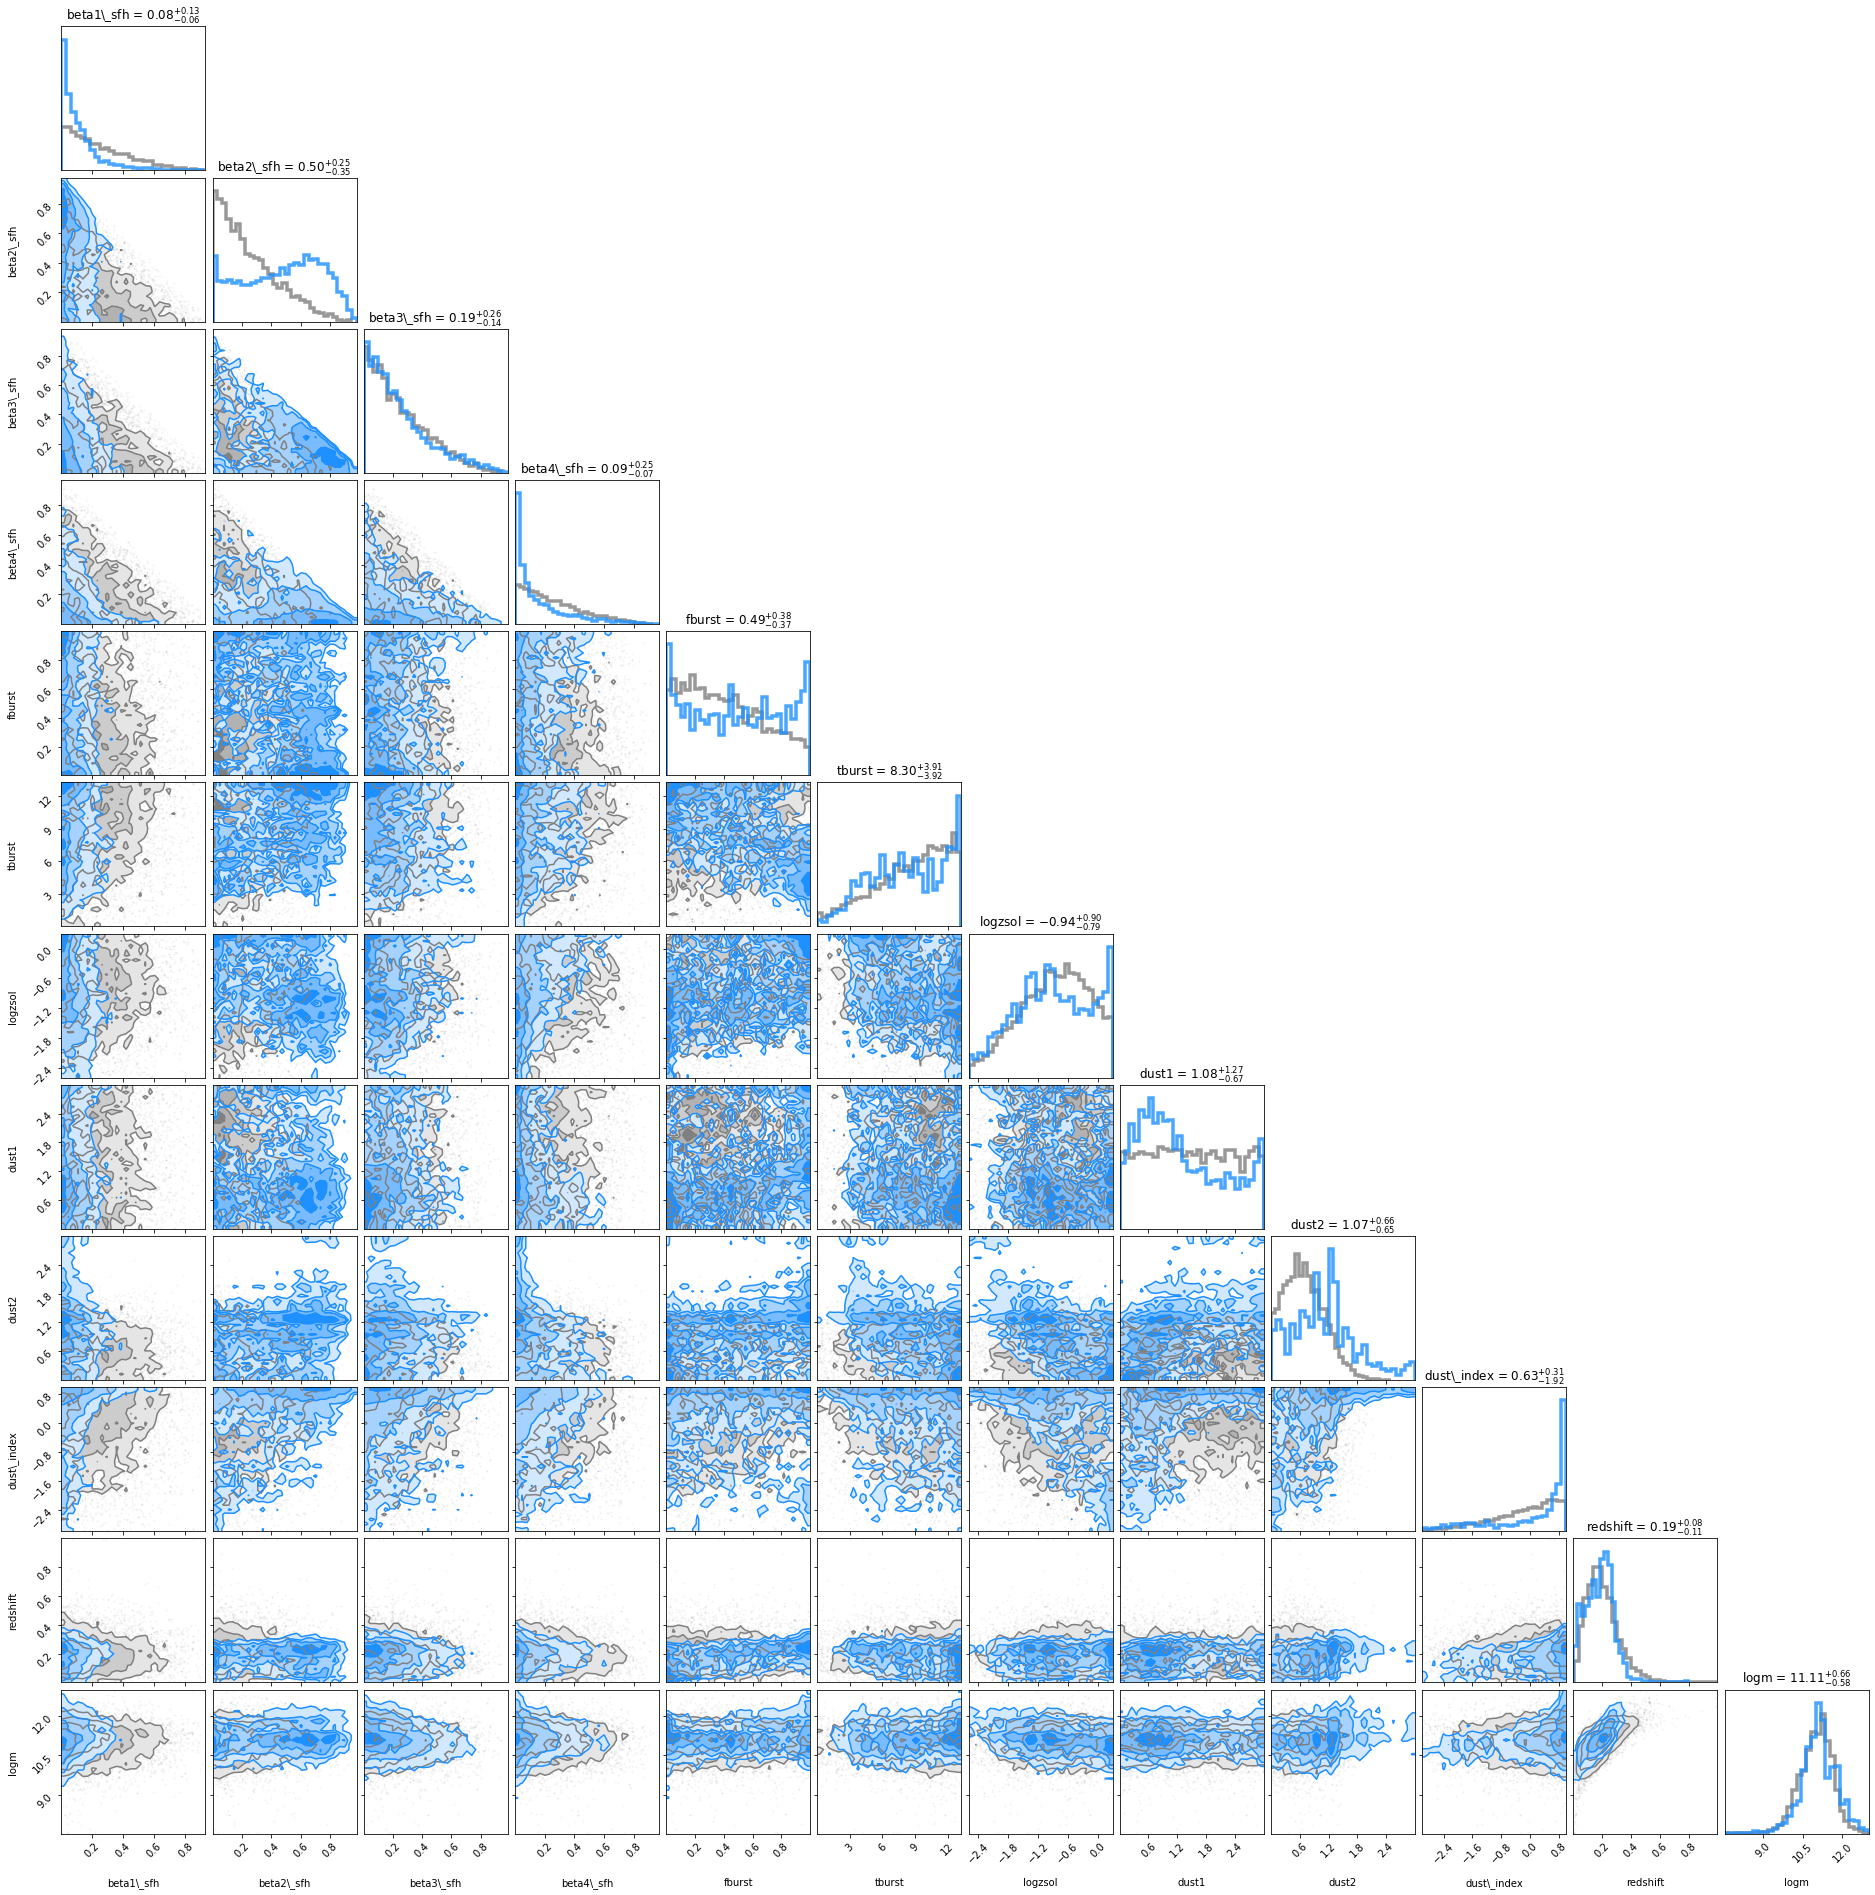

In [51]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

figure = corner.corner(true_params, 
                  labels=_labels, bins=30,
                  color='gray', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)


nf_plot = corner.corner(_samples, 
                        fig=figure,
                  labels=_labels, bins=30,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

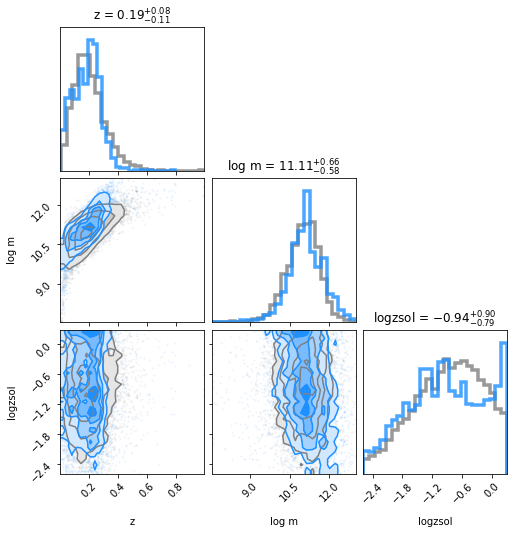

In [52]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
#                        range=[[0, 1], [8, 13], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:-1], _samples[:, -1:], _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [46]:
np.sort(true_params[:, -2])

array([0.00657144, 0.0066278 , 0.00664884, ..., 0.97983915, 0.98794556,
       0.9928388 ])

(array([193., 466., 620., 746., 738., 645., 528., 369., 229., 154., 125.,
         67.,  36.,  32.,  12.,  10.,   8.,   5.,   3.,   1.,   6.,   2.,
          0.,   1.,   4.]),
 array([0.00657144, 0.04602214, 0.08547283, 0.12492352, 0.16437422,
        0.20382491, 0.24327561, 0.2827263 , 0.322177  , 0.36162769,
        0.40107839, 0.44052908, 0.47997977, 0.51943047, 0.55888116,
        0.59833186, 0.63778255, 0.67723325, 0.71668394, 0.75613463,
        0.79558533, 0.83503602, 0.87448672, 0.91393741, 0.95338811,
        0.9928388 ]),
 <BarContainer object of 25 artists>)

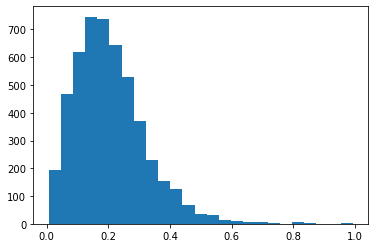

In [66]:
plt.hist(true_params[:, -2], bins=25)
# plt.xlim(0, 0.15)

In [64]:
from popsed.models import NMF_ZH
model = NMF_ZH(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [63]:
params = np.hstack([_samples[:, -1:], _samples[:, :-1]])

In [69]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))
zmw = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=tt[-1], dt=1)
    age[i] = model.tage_MW(tt[:-1], zred=tt[-1])
    zmw[i] = model.Z_MW(tt[:-1], zred=tt[-1])

In [78]:
redshift = params[:, -1]
logmstar = params[:, 0]
logzsol = np.log10(zmw / 0.019)

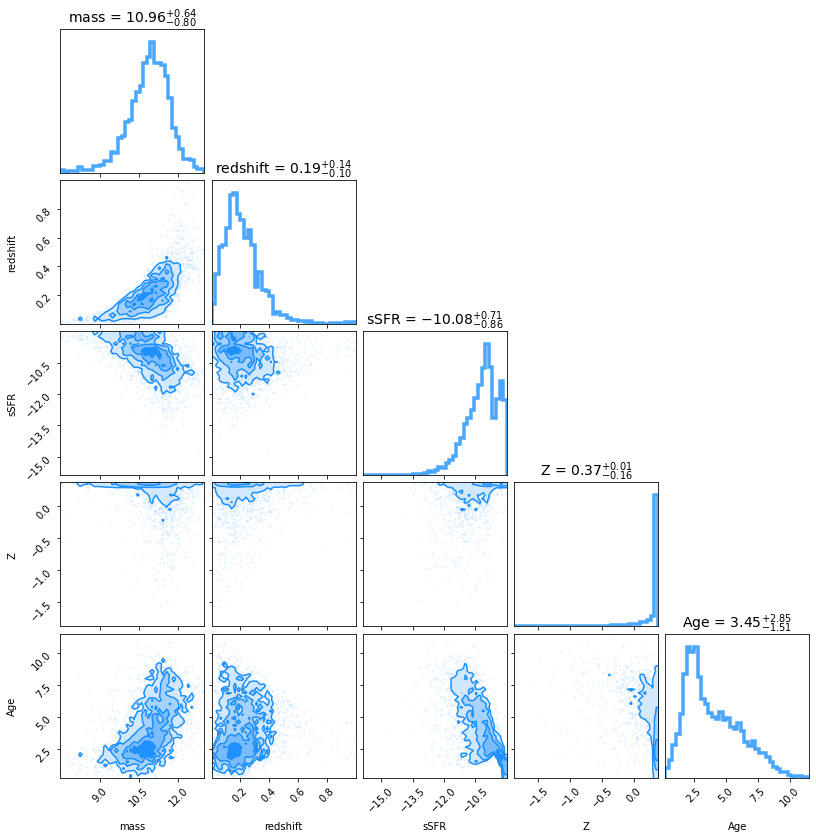

In [79]:
figure = corner.corner(np.vstack([logmstar, redshift, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['mass','redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [35]:
a, b = np.histogram(z_mass_truth[:, 0].ravel(), bins=35, range=(0, 0.5))
b[np.argmax(a)]

0.15714286

In [59]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()

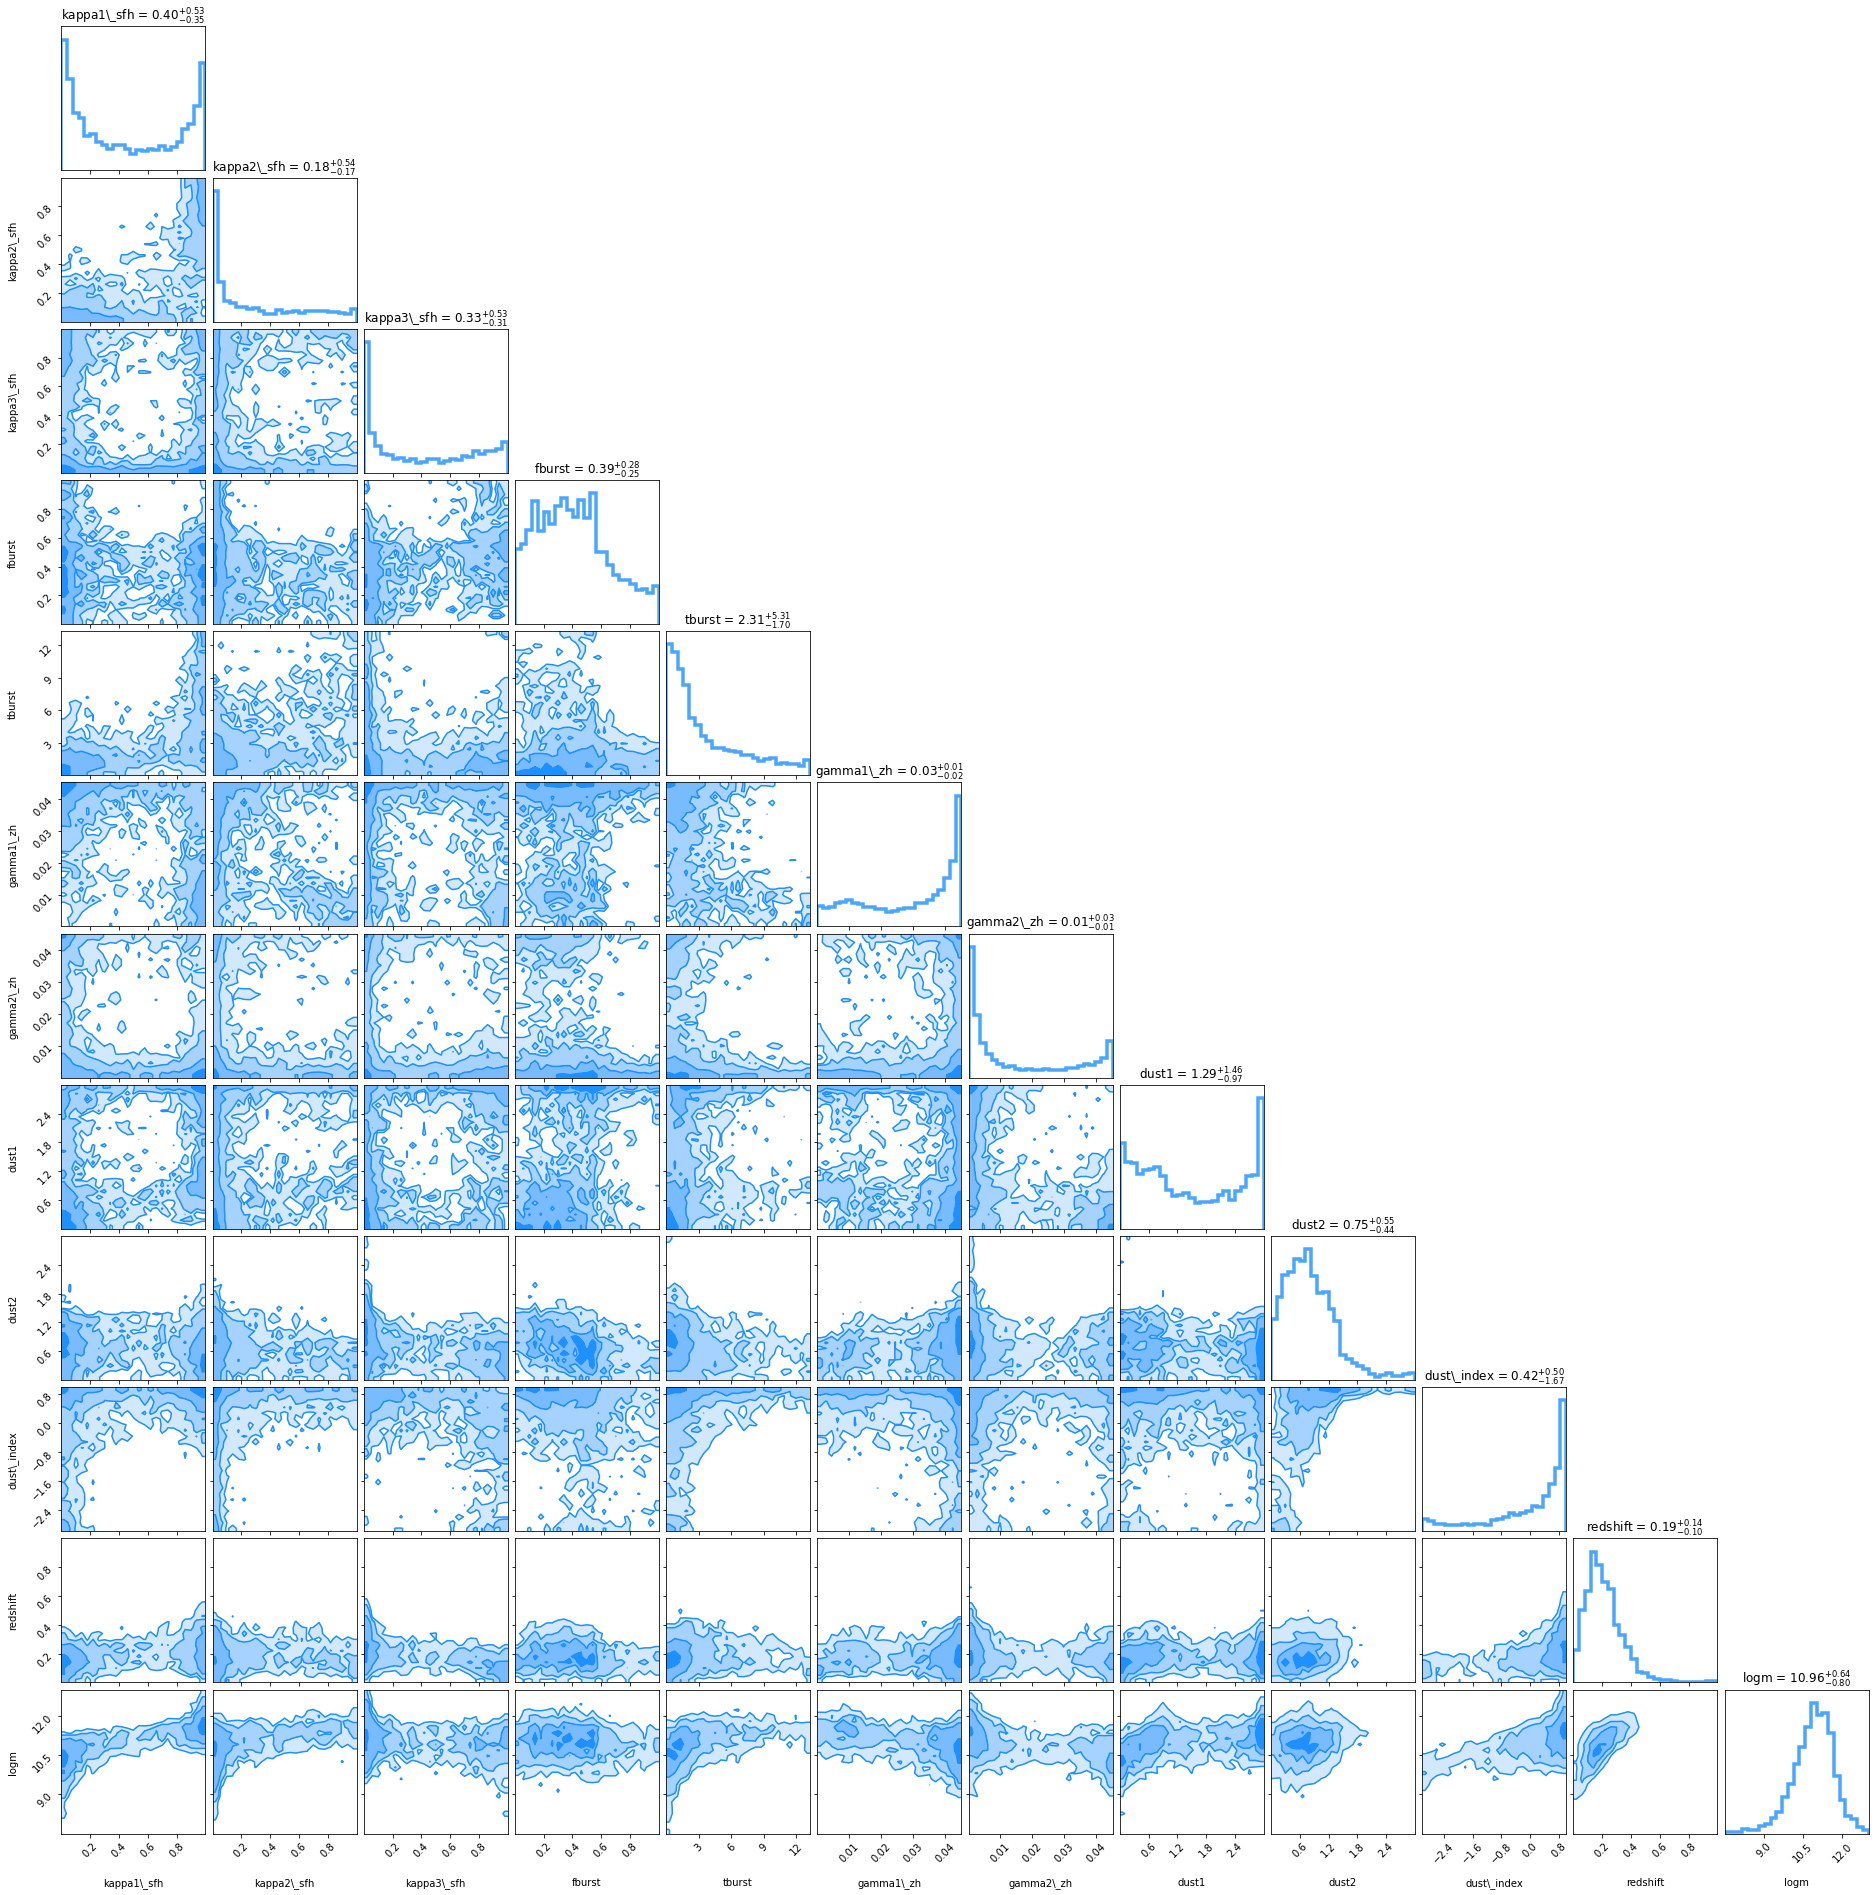

In [60]:
_labels = [f'kappa{i}_sfh' for i in range(1,4)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples_unt, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))